# Random Fantasy Map Generator

## Inspiration

I wanted to make maps that look like something you'd find at the back of one of the cheap paperback fantasy novels of my youth. I always had a fascination with these imagined worlds, which were often much more interesting than whatever luke-warm sub-Tolkien tale they were attached to.

At the same time, I wanted to play with terrain generation with a physical basis. There are loads of articles on the internet which describe terrain generation, and they almost all use some variation on a fractal noise approach, either directly (by adding layers of noise functions), or indirectly (e.g. through midpoint displacement). These methods produce lots of fine detail, but the large-scale structure always looks a bit off. Features are attached in random ways, with no thought to the processes which form landscapes. I wanted to try something a little bit different.

There are a few different stages to the generator. First we build up a height-map of the terrain, and do things like routing water flow over the surface. Then we can render the 'physical' portion of the map. Finally we can place cities and 'regions' on the map, and place their labels.

In [26]:
import random

defaultExtent = {
    "width": 1,
    "height": 1
}

def generatePoints(n, extent=defaultExtent):
    pts = []
    for i in range(n):
        pts.append([(random.random()- 0.5) * extent["width"], (random.random() - 0.5) * extent["height"]])
    return pts

points = generatePoints(256)

## Grids

To represent the heightmap, first we need a grid of points. Although it can be simpler to work on a regular square grid, I much prefer to work on an irregular set of points for something like this. With a regular grid, it's very easy to run into weird artifacts, and you often have to do a lot of postprocessing to hide the effects of the grid. If you use an irregular grid, then there are a few things which are more complicated, but the structure of the grid helps to give the map a rough, organic feel, and you never have to worry about nasty linear artifacts in the finished product.

The approach I use is the same as in this [article](http://www-cs-students.stanford.edu/~amitp/game-programming/polygon-map-generation/), which is one of the better references out there on how to do non-fractal terrain generation. I won't go into too much detail here because that article explains it very clearly, with lots of diagrams.

I start by selecting points at random within the map. These points tend to be a bit clumpy and uneven, so I use [Lloyd relaxation](https://en.wikipedia.org/wiki/Lloyd%27s_algorithm) to improve the point set. For speed, I only use one iteration of this process, but you can repeat it as many times as you like. There are rapidly diminishing returns after a few iterations though.

All of the calculations are actually carried out on the 'dual points' of the original point set, which correspond to the corners of the Voronoi polygons. This has the advantage that the number of neighbours per node is fixed at three, which helps in some parts of the code.

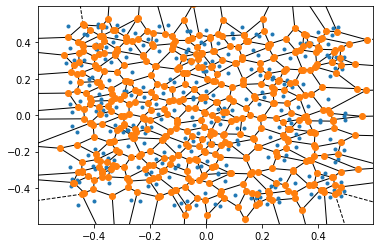

In [27]:
from scipy.spatial import Voronoi, voronoi_plot_2d
# Improve points create Voronoi diagram

vor = Voronoi(points)
fig = voronoi_plot_2d(vor)

## Rough outlines

One of the difficulties of creating landscapes in a realistic way is that real landscapes aren't created all at once. Instead, they evolve from earlier landscapes, which in turn evolved from even earlier landscapes, and so on back for billions of years. There's no good way to simulate this process in a reasonable amount of time, so we need to cheat slightly.

Rather than an infinite regress of older landscapes, I start with a simple 'proto-landscape', built with geometric primitives. This lets me control the broad outlines of the terrain, while leaving the details for the more physical processes to fill in later.

Some useful primitives which we can add together:

- Constant slope - if you want to pretend this is physically motivated, think of it as tectonic uplift on one side of the map
- Cone shapes - these can be islands or mountains, or if inverted, lakes or seas
- Rounded blobs - these make better hills, and can be scattered all around to make a noisy surface

We also have a few operations which are handy:

- Normalize - rescale the heights to lie in the range 0-1
- Round - normalize, then take the square root of the height value, to round off the tops of hills
- Relax - replace each height value with the average of its neighbours, to smooth the surface
- Set sea level - translate the heightmap up or down so that a particular quantile is at zero

The particular sequence of primitives and operations used can be varied to produce different kinds of landscape, such as coastlines, islands and mountain ranges.